In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import (
    read_ts_tree,
    ts_read_daily_tickets,
    get_proper_tree,
)

У нас есть два датасета:
- подневные агрегаты кол-ва тикетов в разрезе очереди
- иерархия тикетов

In [2]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))
tree = read_ts_tree(get_correct_data_path("dataset_tickets_timeseries/tree_queue.tsv"))

### Краткий обзор данных по кол-ву тикетов

In [3]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


In [4]:
df.shape

(418327, 3)

In [5]:
dmin, dmax = df["date"].min().date(), df["date"].max().date()
print(f"Данные с {dmin} по {dmax}, {(dmax-dmin).days + 1} дней")

Данные с 2017-01-01 по 2020-09-30, 1369 дней


В среднем на день приходилось 11 тысяч тикетов

In [6]:
df_total = df.groupby("date")["new_tickets"].sum()
df_total.describe().round()

count     1369.0
mean     11279.0
std       5814.0
min       1648.0
25%       6745.0
50%       9821.0
75%      14395.0
max      31888.0
Name: new_tickets, dtype: float64

In [7]:
if df.duplicated(["date", "queueId"]).sum() == 0:
    print("Нет дубликатов очередей в разрезе даты")

Нет дубликатов очередей в разрезе даты


В среднем в сутки приходили тикеты в 300 очередей.

In [8]:
df.groupby("date").count()["queueId"].describe().round()

count    1369.0
mean      306.0
std        85.0
min       158.0
25%       233.0
50%       282.0
75%       377.0
max       532.0
Name: queueId, dtype: float64

### Обзор данных по иерархии очередей

In [9]:
tree.head()

,parentQueueId,childrenIds
0,2010,"[2330, 2010]"
1,1571,"[3085, 1571]"
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,..."
3,2538,"[3252, 2583, 2538]"
4,100192,"[100193, 100192]"


In [10]:
tree.shape

(337, 2)

В childrenIds хранятся ID всех дочерних очередей (включая все поддерево). Также всегда включена сама очередь в childrenIds. Есть проблема частичных данных, так как у некоторых корневых очередей была слишком длинная строка, и в файле эти очереди обрезаны.

In [11]:
print(
    f"Максимальная длина, после которой был обрезан список (+1 из-за добавления самой очереди): {tree['childrenIds'].apply(len).max()}"
)

Максимальная длина, после которой был обрезан список (+1 из-за добавления самой очереди): 101


### Сколько выпавших очередей (есть в данных, но нет в иерархии)

In [12]:
all_queues_in_hierarchy = set()


def update_queues_hierarchy(row):
    all_queues_in_hierarchy.add(row["parentQueueId"])
    for children in row["childrenIds"]:
        all_queues_in_hierarchy.add(children)


tree.apply(update_queues_hierarchy, axis=1)
None

In [13]:
all_queues = set(df["queueId"].unique())
queues_not_in_hierarchy = all_queues - all_queues_in_hierarchy
print(f"В иерархии нет {len(queues_not_in_hierarchy)} очередей, которые есть в данных")
print(
    f"В данных {len(all_queues)} уникальных очередей, в иерархии {len(all_queues_in_hierarchy)} уникальных очередей"
)

В иерархии нет 346 очередей, которые есть в данных
В данных 828 уникальных очередей, в иерархии 1651 уникальных очередей


пример выпавших очередей

In [14]:
print(list(queues_not_in_hierarchy)[:10])

[100353, 100354, 100355, 100356, 100357, 100365, 100401, 100404, 100407, 100408]


Скорее всего, снапшот иерархии был сделан и выгружен в апреле 2019, а потом мы видим резкий рост потерянных очередей в данных

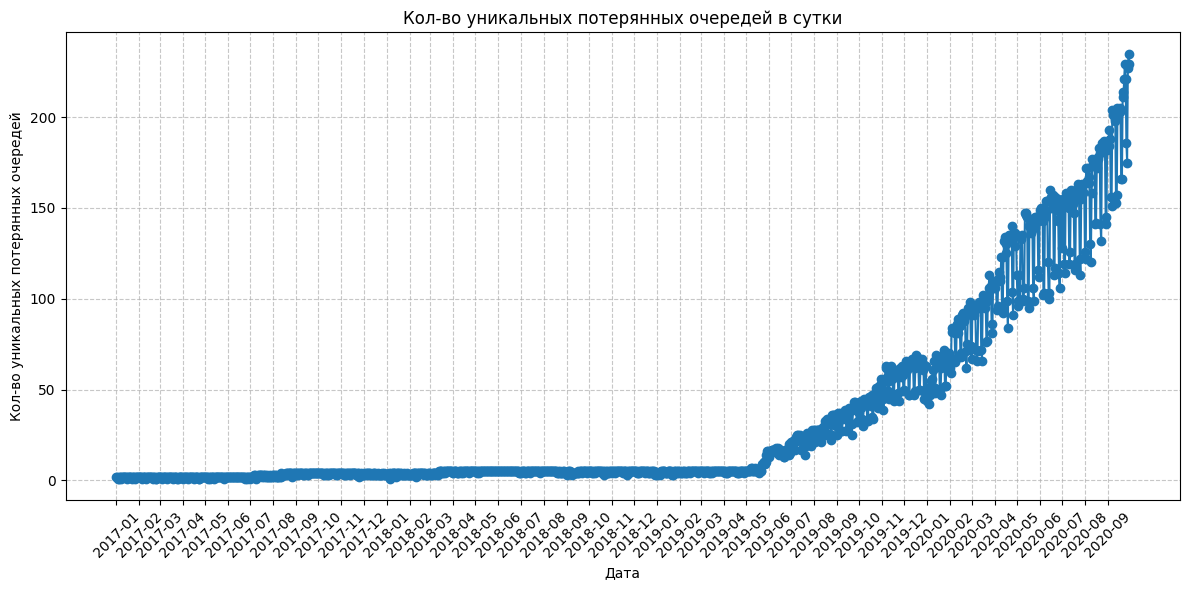

In [15]:
unique_queues = (
    df[df["queueId"].isin(queues_not_in_hierarchy)]
    .groupby("date")["queueId"]
    .nunique()
    .reset_index()
)

plt.figure(figsize=(12, 6))
plt.plot(unique_queues["date"], unique_queues["queueId"], marker="o")
plt.title("Кол-во уникальных потерянных очередей в сутки")
plt.xlabel("Дата")
plt.ylabel("Кол-во уникальных потерянных очередей")

plt.grid(True, linestyle="--", alpha=0.7)

months = pd.date_range(
    start=unique_queues["date"].min(),
    end=unique_queues["date"].max(),
    freq="MS",
)
plt.xticks(months, [d.strftime("%Y-%m") for d in months], rotation=45)

plt.tight_layout()
plt.show()

### Насколько потерянные очереди большие

In [16]:
df_extra_queue = (
    df[df.queueId.isin(queues_not_in_hierarchy)]
    .groupby("queueId")["new_tickets"]
    .sum()
    .sort_values(ascending=False)
)
df_extra_queue[:10]

queueId
100644    225158
100814     63307
100404     43099
100751     34374
100907     34271
100571     31174
100869     29974
100919     29759
100895     25059
100815     24915
Name: new_tickets, dtype: int64

In [17]:
print(
    f"Доля тикетов выпавших очередей: {df_extra_queue.sum() / df['new_tickets'].sum():.2%}"
)

Доля тикетов выпавших очередей: 8.03%


Видна выпавшая из иерархии очередь `100644`

In [18]:
(df.groupby("queueId")["new_tickets"].sum().sort_values(ascending=False))[:10]

queueId
1866      495259
3232      483591
3730      315986
3836      244251
2709      235990
25        233598
3602      230378
100644    225158
2200      224805
29        216448
Name: new_tickets, dtype: int64

## Анализ иерархии очередей

In [19]:
tree

,parentQueueId,childrenIds
0,2010,"[2330, 2010]"
1,1571,"[3085, 1571]"
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,..."
3,2538,"[3252, 2583, 2538]"
4,100192,"[100193, 100192]"
...,...,...
332,9,"[9, 1511, 1002]"
333,2438,"[2727, 2438]"
334,2321,"[2321, 2927]"
335,2842,"[2846, 2842, 2820, 2843, 2885]"


### Восстановление настоящей иерархии

Данный код был получен по запросу в gpt-o1 с описание задачи и требованием восстановить иерархию как возможно, и провести валидацию решения

In [20]:
tree_full = get_proper_tree(tree)

The hierarchy is valid.


Теперь у нас на очередь есть прямые и все наследники, это полезно для иерархических моделей

In [21]:
tree_full

,queueId,level,immediateDescendants,allDescendants
0,1,2,[100286],"[1, 100286]"
1,4097,3,[],[4097]
2,5,1,"[6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 117,...","[5, 6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 1..."
3,6,2,[],[6]
4,7,2,[100253],"[7, 100253]"
...,...,...,...,...
1646,4052,2,"[4137, 1062]","[1062, 2835, 4052, 4137]"
1647,4062,4,[],[4062]
1648,4082,2,[],[4082]
1649,4087,2,"[3536, 3836]","[3536, 3836, 4087]"


### Анализ уровня очередей

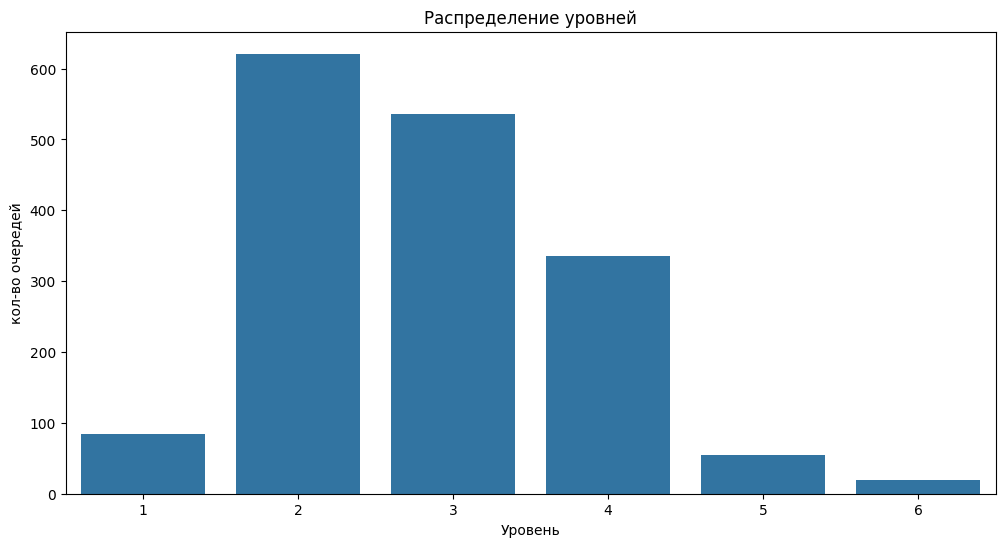

In [22]:
plt.figure(figsize=(12, 6))
depth_counts = tree_full["level"].value_counts().sort_index()
sns.barplot(x=depth_counts.index, y=depth_counts.values)
plt.title("Распределение уровней")
plt.xlabel("Уровень")
plt.ylabel("кол-во очередей")
plt.show()

In [23]:
print(f"Всего тикетов: {df['new_tickets'].sum():,}")

Всего тикетов: 15,440,382


## Топ очередей (включая всю иерархию)

Эти данные не аддитивные, так как они лишь отображают подмножество очередей исходя из иерархии

In [24]:
tree_full["full_load"] = tree_full.apply(
    lambda row: df[df["queueId"].isin(row["allDescendants"])]["new_tickets"].sum(),
    axis=1,
)

Видим ситации, когда у корневой очереди большое кол-во прямых наследников, но все они пустые по данным.

In [25]:
tree_full["descendants_count"] = tree_full["immediateDescendants"].apply(len)

tree_full[(tree_full["level"] == 1)].nlargest(10, "descendants_count")

,queueId,level,immediateDescendants,allDescendants,full_load,descendants_count
812,2230,1,"[32, 36, 37, 38, 100, 106, 109, 342, 4627, 473...","[32, 36, 37, 38, 100, 106, 109, 342, 1082, 133...",0,78
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237,36
1048,2522,1,"[12, 27, 31, 49, 91, 93, 105, 4402, 402, 4592,...","[12, 27, 31, 49, 91, 93, 105, 107, 332, 402, 7...",0,28
115,182,1,"[251, 261, 271, 281, 291, 301, 311, 321, 322, ...","[182, 251, 261, 271, 281, 291, 301, 311, 321, ...",0,27
641,2036,1,"[2037, 2040, 2041, 2042, 2043, 2047, 2049, 205...","[2036, 2037, 2040, 2041, 2042, 2043, 2047, 204...",0,24
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296,23
2,5,1,"[6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 117,...","[5, 6, 43, 51, 53, 68, 76, 82, 92, 102, 108, 1...",0,21
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019,21
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818,16
91,4212,1,"[4222, 4217, 4227, 4232, 4237, 4242, 4247, 465...","[4005, 4009, 4017, 4152, 4212, 4217, 4222, 422...",0,14


In [26]:
top_n = 20
print(
    "\n".join(
        f"Queue {row['queueId']:>5}, level {row['level']}: {row['full_load']:,}"
        for _, row in tree_full.nlargest(top_n, "full_load").iterrows()
    )
)

Queue    10, level 1: 2,463,146
Queue  1866, level 1: 1,470,013
Queue   742, level 1: 1,387,729
Queue    34, level 1: 1,247,019
Queue  2657, level 2: 1,243,017
Queue  4447, level 1: 1,121,534
Queue  1871, level 1: 1,006,818
Queue  4397, level 1: 986,415
Queue   115, level 1: 896,296
Queue  2002, level 1: 825,237
Queue  4412, level 2: 792,209
Queue  4147, level 1: 681,754
Queue  2199, level 2: 572,166
Queue  3602, level 2: 546,364
Queue  3232, level 3: 483,591
Queue  3936, level 1: 431,173
Queue  2372, level 2: 417,175
Queue  4087, level 2: 397,990
Queue  2709, level 1: 397,720
Queue    25, level 2: 365,692


Заметим, что очередь 2657 входит в очередь 10, но все равно очень большая

In [27]:
tree_full[tree_full["immediateDescendants"].apply(lambda x: 2657 in x)]

,queueId,level,immediateDescendants,allDescendants,full_load,descendants_count
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146,10


А эта очередь входит в очередь 1, 2 уровней и сама в себе

In [28]:
tree_full[tree_full["allDescendants"].apply(lambda x: 3232 in x)]

,queueId,level,immediateDescendants,allDescendants,full_load,descendants_count
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415,8
791,2199,2,"[100115, 3232]","[2199, 3232, 100115]",572166,2
1506,3232,3,[],[3232],483591,0


Также есть корневые очереди, но с очень малым кол-вом тикетов. Это может быть из-за стертых значений или каких-то ошибок. Так как мы не знаем точную иерархию, то считаем такие очереди корневыми. Или это правда пустые очереди.

<Axes: >

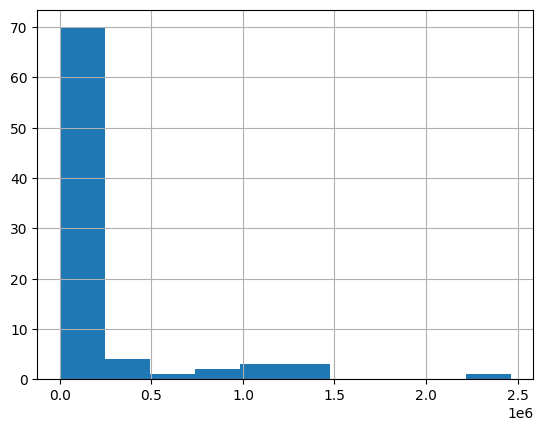

In [29]:
tree_full[tree_full["level"] == 1]["full_load"].hist()

22 корневые очереди с ненулевой нагрузкой

In [30]:
tree_full[(tree_full["level"] == 1) & (tree_full["full_load"] != 0)][
    "full_load"
].sort_values(ascending=False).reset_index(drop=True)

0     2463146
1     1470013
2     1387729
3     1247019
4     1121534
5     1006818
6      986415
7      896296
8      825237
9      681754
10     431173
11     397720
12     342116
13     332265
14     232449
15     181486
16      95795
17      51632
18      30301
19       9758
20       8661
21       1242
Name: full_load, dtype: int64